# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [19]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
!pip install torchinfo

In [2]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output

sns.set(font_scale=1, style="darkgrid", palette="Set2")
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [3]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 104446627.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50389223.72it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24586776.39it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8726765.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Проверим размеры датасетов.

In [4]:
len(train_dataset), len(val_dataset)

(60000, 10000)

Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


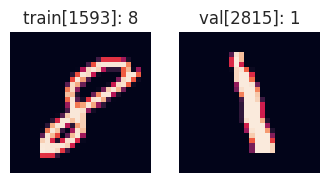

In [5]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

Создайте генераторы батчей.

In [6]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [7]:
models = []

cnn_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=14 * 14 * 32, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
models.append(cnn_1)

cnn_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=7 * 7 * 64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
models.append(cnn_2)

cnn_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=7 * 7 * 64, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
models.append(cnn_3)

cnn_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3 * 3 * 64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
models.append(cnn_4)

cnn_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=7 * 7 * 128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
models.append(cnn_5)

for i in range(5):
    print(
        "Архитетура",
        i + 1,
        "модели:\n",
        summary(models[i], input_size=(64, 1, 28, 28)),
        "\n",
    )

Архитетура 1 модели:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─ReLU: 1-3                              [64, 32, 14, 14]          --
├─Flatten: 1-4                           [64, 6272]                --
├─Linear: 1-5                            [64, 256]                 1,605,888
├─ReLU: 1-6                              [64, 256]                 --
├─Linear: 1-7                            [64, 10]                  2,570
Total params: 1,608,778
Trainable params: 1,608,778
Non-trainable params: 0
Total mult-adds (M): 119.00
Input size (MB): 0.20
Forward/backward pass size (MB): 12.98
Params size (MB): 6.44
Estimated Total Size (MB): 19.62

Архитетура 2 модели:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential     

Определим функции, которые будут необходимы далее.

In [8]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(history["acc"]["train"][-1] * 100)
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(history["acc"]["val"][-1] * 100)
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(X_batch, y_batch, model, criterion, current_loss, current_acc):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, train_loss, train_acc, len(train_batch_gen), "train")

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [9]:
criterion = nn.CrossEntropyLoss()

histories = []
for i in range(5):
    optimizer = torch.optim.Adam(models[i].parameters())
    histories.append(
        train(
            models[i],
            criterion,
            optimizer,
            train_batch_gen,
            val_batch_gen,
            num_epochs=40,
        )
    )
    # Сохраняем веса модели в файл
    torch.save(models[i].state_dict(), "cnn_" + str(i) + ".pth")

Epoch 40 of 40 took 11.399 s
  training loss: 	0.000001
  validation loss: 	0.051775
  training accuracy: 			100.00 %
  validation accuracy: 			99.34 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

Функция для посторения графиков:

In [21]:
def plot_histories(histories, names, title):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    plt.suptitle(title)
    
    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--")
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--")
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

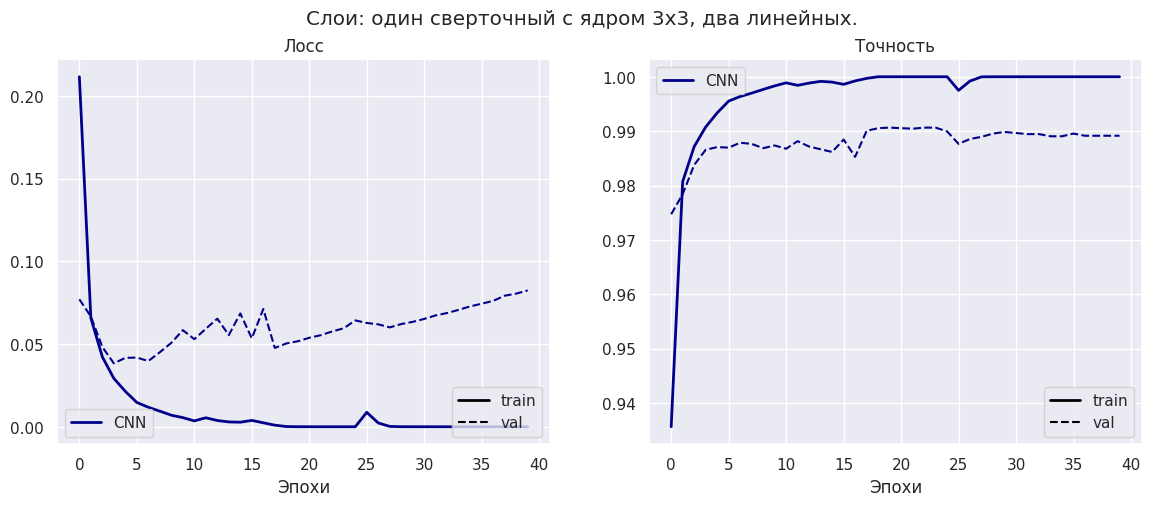

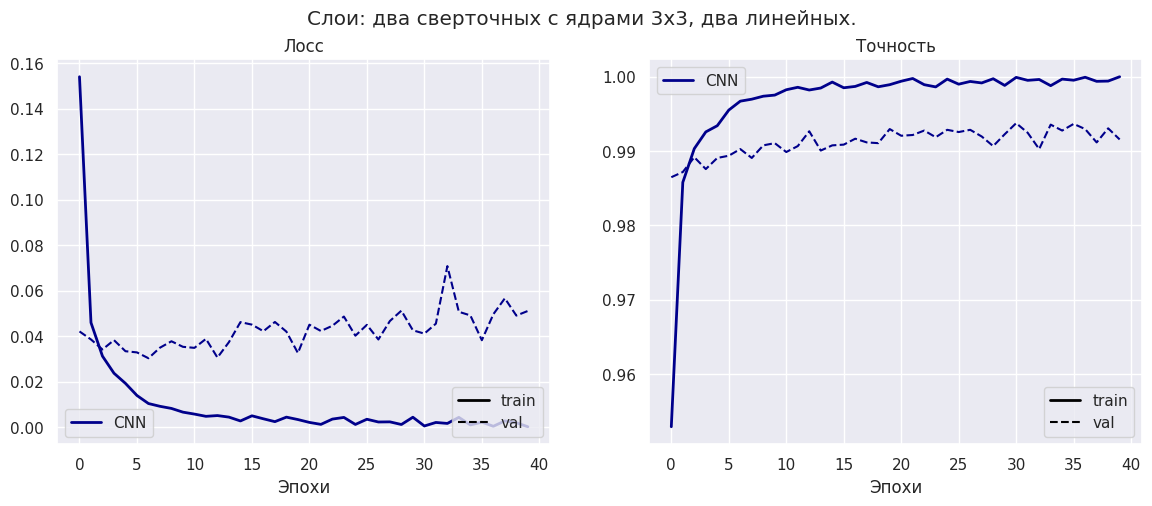

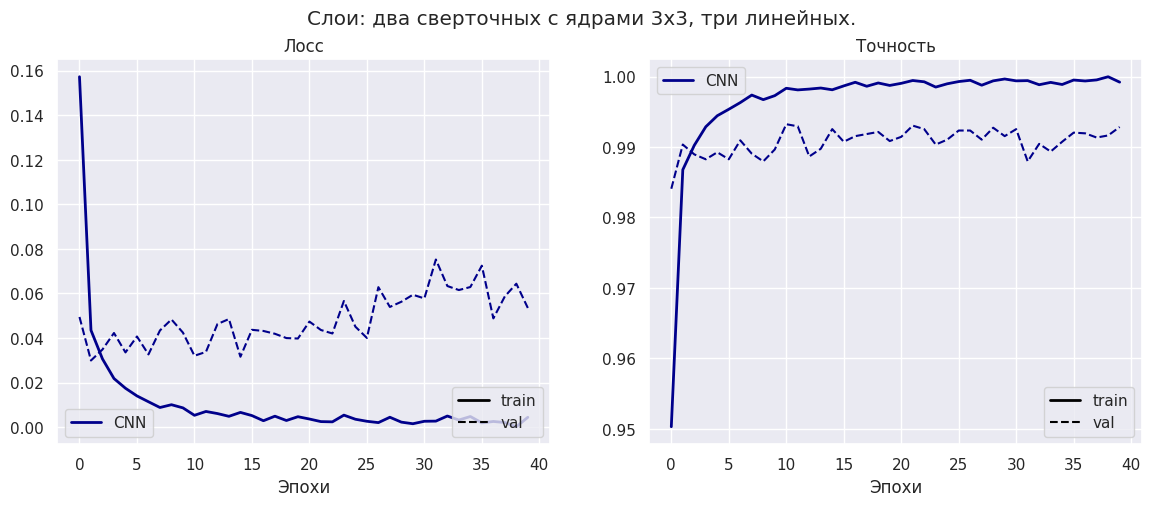

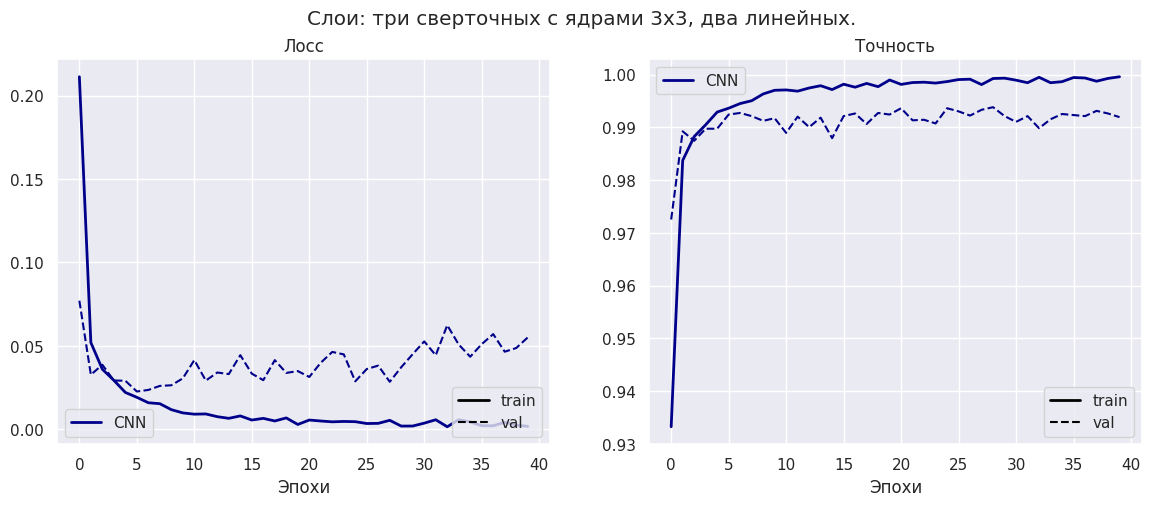

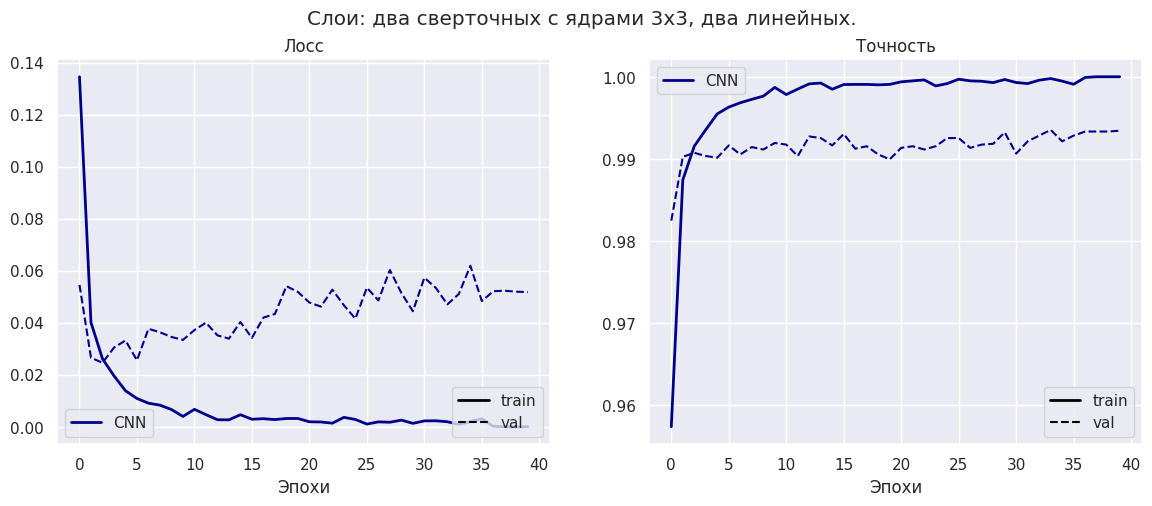

In [16]:
# for h in histories:
#     plot_histories([h], ["CNN"])
plot_histories([histories[0]], ["CNN"], "Слои: один сверточный с ядром 3х3, два линейных.")
plot_histories([histories[1]], ["CNN"], "Слои: два сверточных с ядрами 3х3, два линейных.")
plot_histories([histories[2]], ["CNN"], "Слои: два сверточных с ядрами 3х3, три линейных.")
plot_histories([histories[3]], ["CNN"], "Слои: три сверточных с ядрами 3х3, два линейных.")
plot_histories([histories[4]], ["CNN"], "Слои: два сверточных с ядрами 3х3, два линейных.")

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:** Итак, как видно из графиков, на всех моделях примерно после третьей эпохи происходит переобучние. Тем не менее, необходимая точность достигнута на всех моделях. Однако можно считать, что наиболее эффективной оказалась четертая модель, так как она наименее склонна к переобуению, а также, в точке, после которой начинается переобучние, точность среди всех моделей максимальна - более девяноста процентов. В данной модели используется три сверточных слоя, при том что в остальных - одна или две. Это увеличисвет качество обучние, хоть с этим и увеличивается время обучения.

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

Создадим модели с разными размерами ядра на разных сверточных слоях:

In [17]:
best_models = []

best_cnn_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3 * 3 * 64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
best_models.append(best_cnn_1)

best_cnn_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3 * 3 * 64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
best_models.append(best_cnn_2)

best_cnn_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3 * 3 * 64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
best_models.append(best_cnn_3)

best_cnn_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3 * 3 * 64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
best_models.append(best_cnn_4)

for i in range(4):
    print(
        "Архитетура",
        i + 1,
        "модели:\n",
        summary(best_models[i], input_size=(64, 1, 28, 28)),
        "\n",
    )

Архитетура 1 модели:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          832
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─ReLU: 1-3                              [64, 32, 14, 14]          --
├─Conv2d: 1-4                            [64, 32, 14, 14]          9,248
├─MaxPool2d: 1-5                         [64, 32, 7, 7]            --
├─ReLU: 1-6                              [64, 32, 7, 7]            --
├─Conv2d: 1-7                            [64, 64, 7, 7]            18,496
├─MaxPool2d: 1-8                         [64, 64, 3, 3]            --
├─ReLU: 1-9                              [64, 64, 3, 3]            --
├─Flatten: 1-10                          [64, 576]                 --
├─Linear: 1-11                           [64, 256]                 147,712
├─ReLU: 1-12                             [64, 256] 

Обучим модели:

In [18]:
criterion = nn.CrossEntropyLoss()

best_histories = []
for i in range(4):
    optimizer = torch.optim.Adam(best_models[i].parameters())
    best_histories.append(
        train(
            best_models[i],
            criterion,
            optimizer,
            train_batch_gen,
            val_batch_gen,
            num_epochs=15,
        )
    )
    # Сохраняем веса модели в файл
    torch.save(best_models[i].state_dict(), "best_cnn_" + str(i + 1) + ".pth")

Epoch 15 of 15 took 11.643 s
  training loss: 	0.008150
  validation loss: 	0.042749
  training accuracy: 			99.74 %
  validation accuracy: 			99.17 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

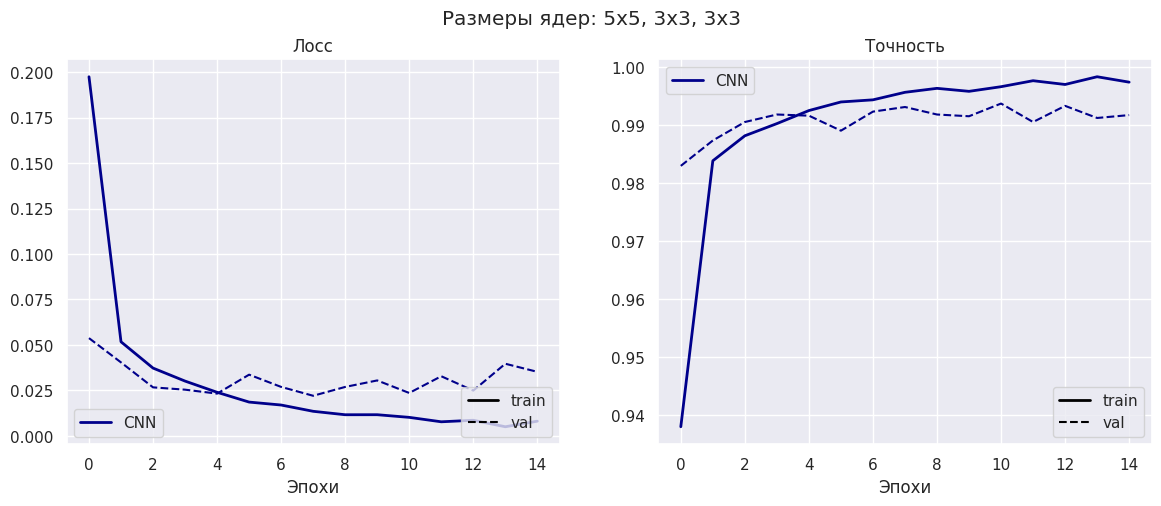

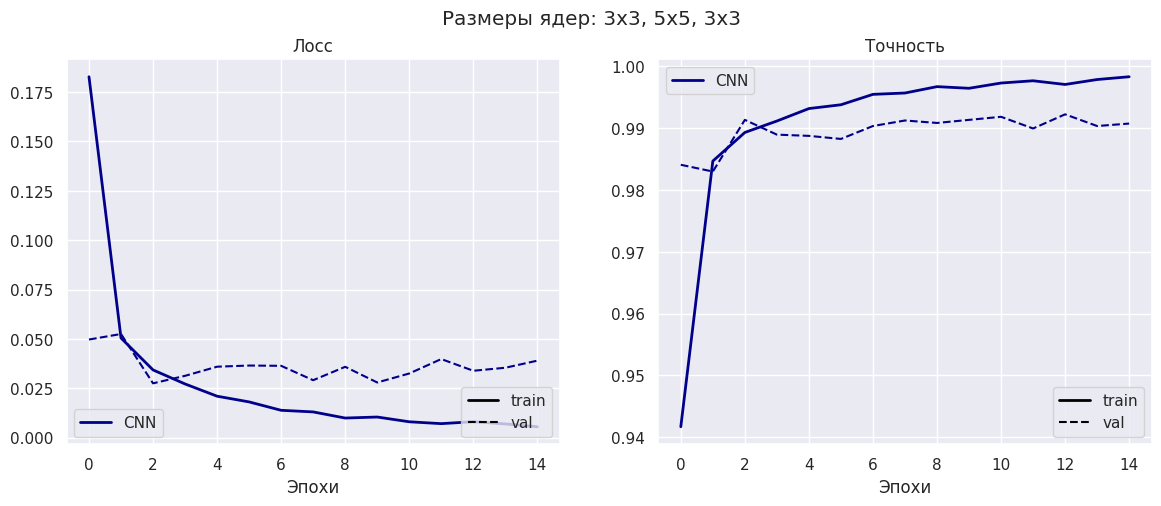

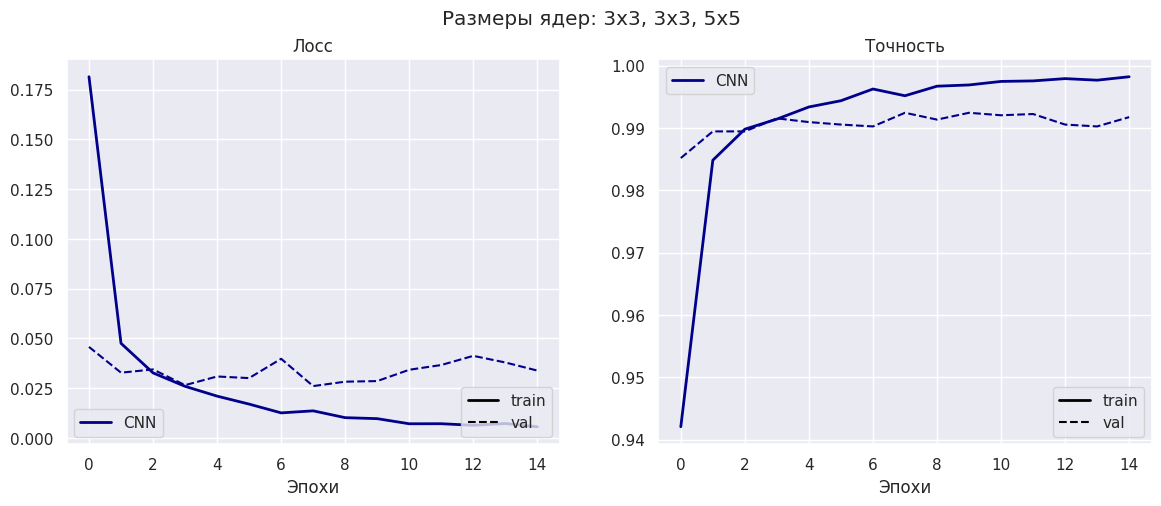

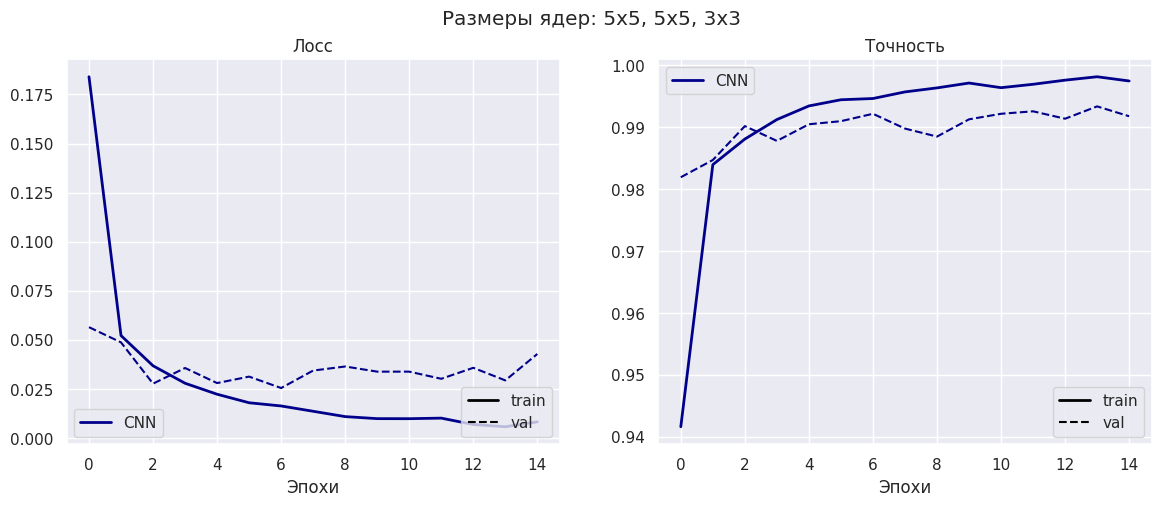

In [23]:
# for h in best_histories:
#     plot_histories([h], ["CNN"])
plot_histories([best_histories[0]], ["CNN"], "Размеры ядер: 5х5, 3х3, 3х3")
plot_histories([best_histories[1]], ["CNN"], "Размеры ядер: 3х3, 5х5, 3х3")
plot_histories([best_histories[2]], ["CNN"], "Размеры ядер: 3х3, 3х3, 5х5")
plot_histories([best_histories[3]], ["CNN"], "Размеры ядер: 5х5, 5х5, 3х3")

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:** Итак, как видим, в конце, когда размерность картинки минимальна, увеличение размера ядра не дает результата (версии вторая - четвертая). Если же использовать ядро побольше в более ранних слоях, то качество улучшается (версия первая, где размер 5х5 на первом слое и 3х3 на втором и третьем). То есть бОльшие размеры ядра помогают увеличить тоность, а время обучения сильно не увеличивается.

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [33]:
best_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3 * 3 * 64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [34]:
new_val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

best_cnn.load_state_dict(
    torch.load("/kaggle/working/best_cnn_1.pth", map_location=torch.device(device))
#     torch.load("best_cnn_1.pth", map_location=torch.device(device))
)

best_cnn.train(False)

mistakes = []

correct_pred = {classname: 0 for classname in range(10)}
total_pred = {classname: 0 for classname in range(10)}


with torch.no_grad():
    for X_batch, y_batch in new_val_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_cnn(X_batch)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(y_batch, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            else:
                if len(mistakes) < 15:
                    mistakes.append((X_batch, label.item(), prediction.item()))
            total_pred[label.item()] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class", classname, "is", round(accuracy, 2))

Accuracy for class 0 is 99.08
Accuracy for class 1 is 99.91
Accuracy for class 2 is 99.22
Accuracy for class 3 is 99.21
Accuracy for class 4 is 99.08
Accuracy for class 5 is 98.88
Accuracy for class 6 is 99.37
Accuracy for class 7 is 98.93
Accuracy for class 8 is 99.08
Accuracy for class 9 is 98.81


Рассмотрим примеры, когда нейросеть выдала неправильную метку:

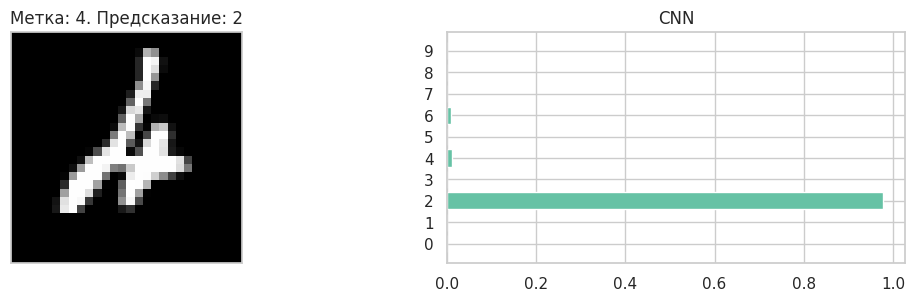

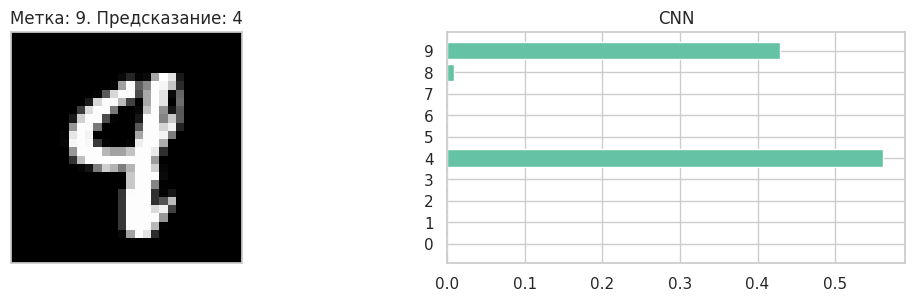

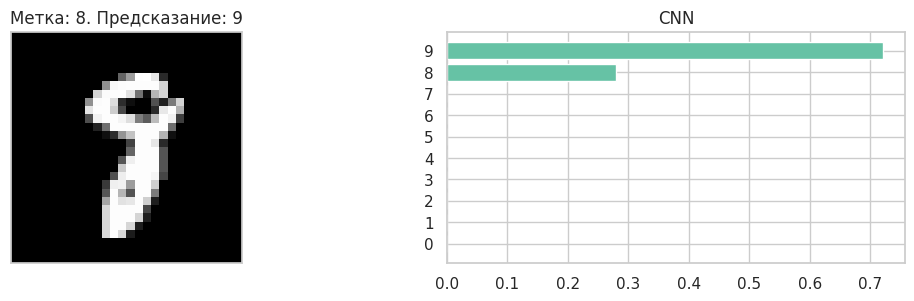

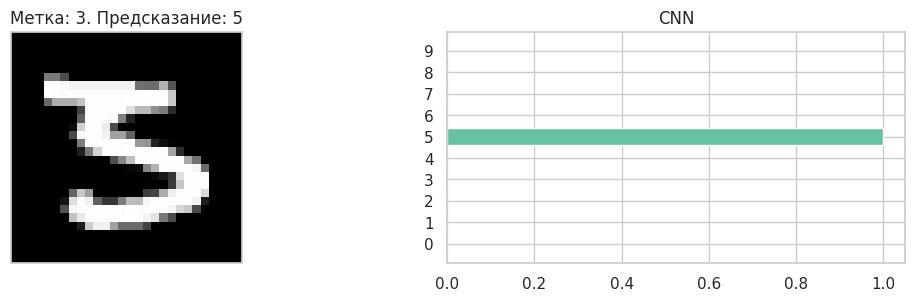

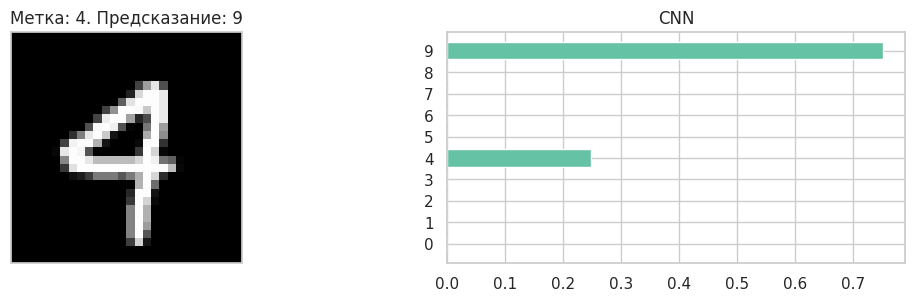

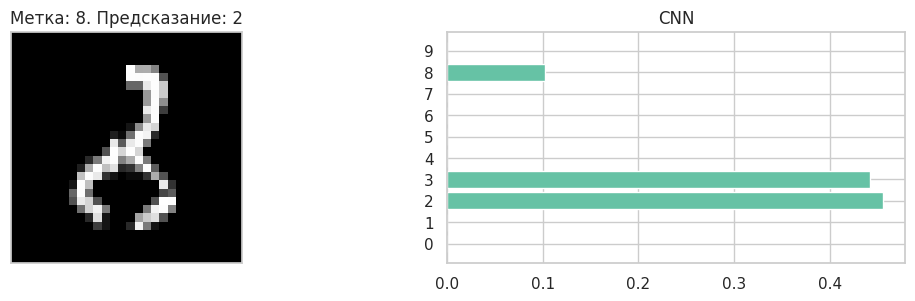

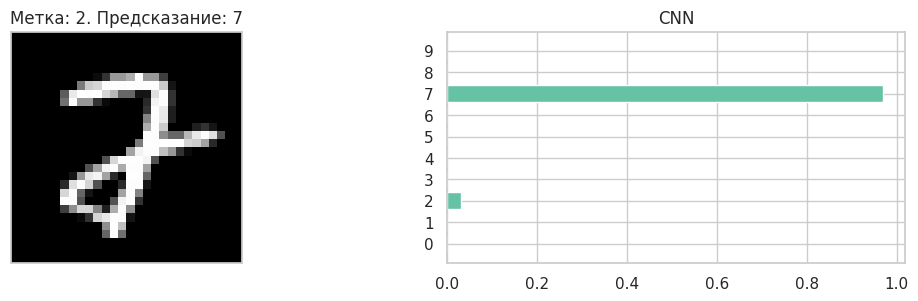

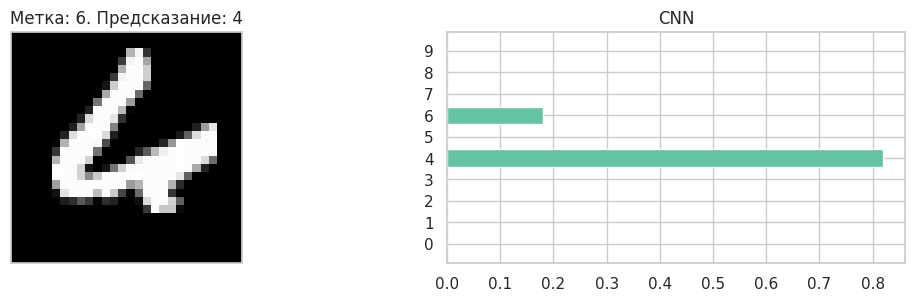

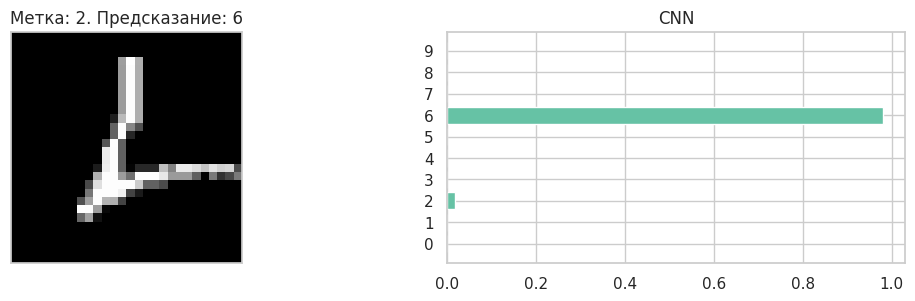

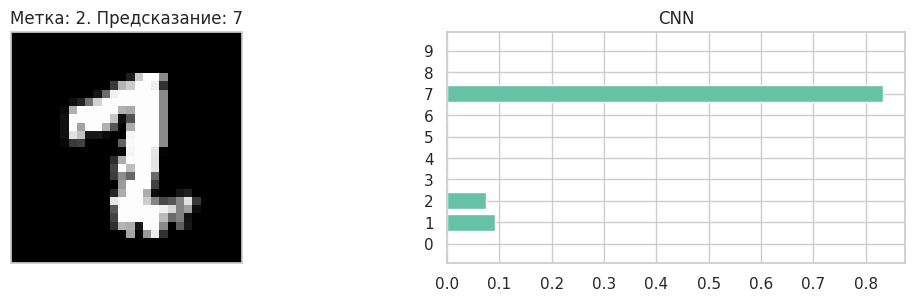

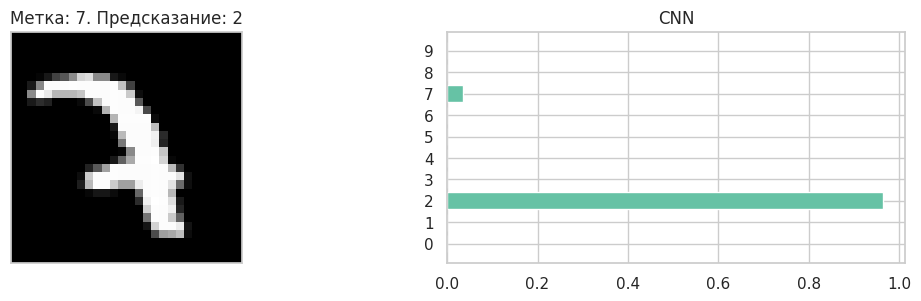

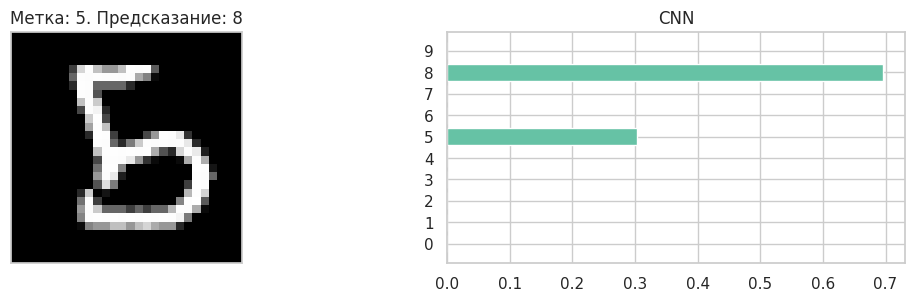

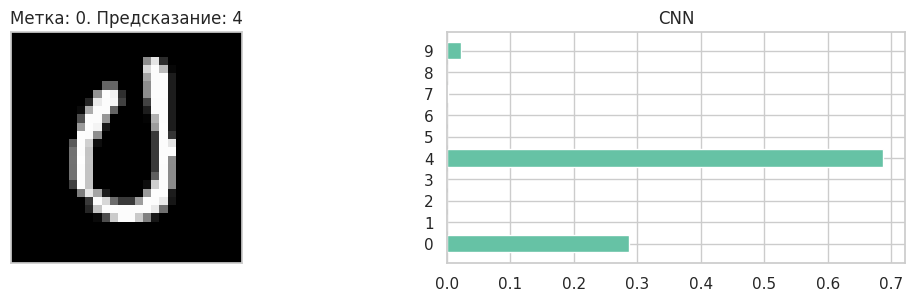

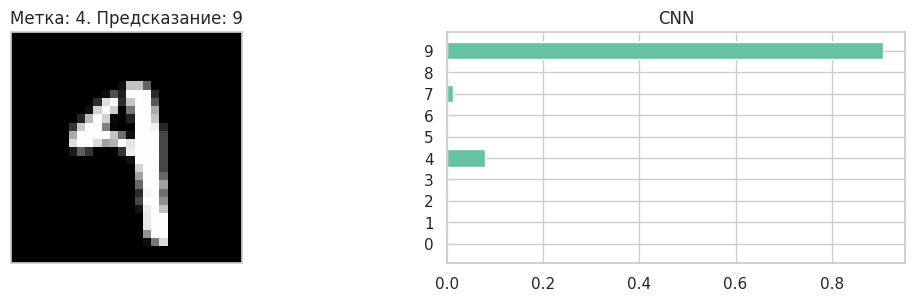

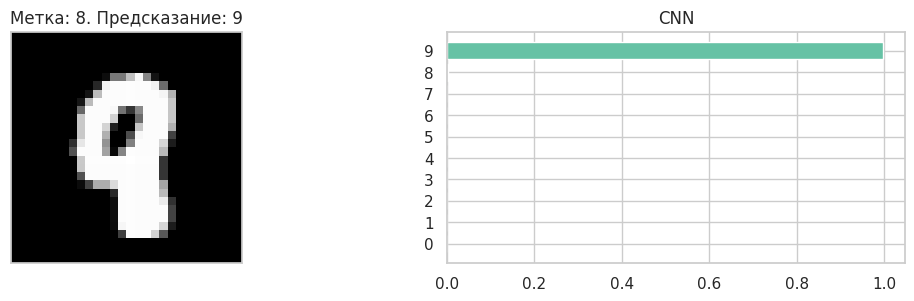

In [45]:
# for i in range(15):
#     _, label, pred = mistakes[i]
#     print("Label:", label, "|", "Prediction:", pred


# for images, label, pred in mistakes:
#     print("Метка:", label, "Предсказание:", pred)
#     plt.imshow(
#         np.transpose(torchvision.utils.make_grid(images.cpu()).numpy(), (1, 2, 0))
#     )
#     plt.show()
    
    
# for i in np.random.randint(0, len(val_dataset), 5):
for image, label, pred in mistakes:
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(13, 3))


        plt.subplot(1, 2, 1)
#         plt.imshow(image.permute((1, 2, 0)))
        plt.imshow(np.transpose(torchvision.utils.make_grid(image.cpu()).numpy(), (1, 2, 0)))
        plt.title("Метка: " + str(label) + ". Предсказание: " + str(pred))
        plt.xticks([])
        plt.yticks([])

        # Не забываем выключить градиенты на момент вычислений
        with torch.no_grad():
            logits_cnn = best_cnn(image.to(device))[0].cpu()

        prob_cnn = torch.softmax(logits_cnn, dim=0)

        plt.subplot(1, 2, 2)
        plt.barh(classes, prob_cnn)
        plt.title("CNN")

**Ответ:** Как видим, точность по классам не очень равномерна. Хуже всех модель справилась с классом "9". Вероятнее всего, потому, что этот класс одновременно похож на классы "8", "5", "2", которые тоже предсказались хуже остальных. Также, рассмотренные изображения показывают, что модель не справилась именно в тех случаях, когда изображение настолько неудачное, что и челочеку было бы нелегко определить, какое это число. Но даже в таких ситуациях, как видно из оценки вероятностей по классам, среди кандидатов на предсказание чаще всего были и истинные значения меток в том числе.

**Вывод по всей задаче:** Итак, мы рассмотрели несколько нейронных сетей с разным количеством слоев и разными размерами ядра. В результате лучшей точности удалось добиться при трех сверточных слоях, где на первых двух ядро имело размеры 5х5, а на третьем - 3х3, и двух линейных слоев. При этом точность оказалась выше 98%, а ошибки модель чаще всего допускала в ситуациях, когда действительно непонятно, какой класс изображен.

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [22]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

In [ ]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория

Cloning into 'Neural-Style-Transfer'...

remote: Enumerating objects: 379, done.

remote: Counting objects: 100% (154/154), done.

remote: Compressing objects: 100% (119/119), done.

remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225

Receiving objects: 100% (379/379), 92.21 MiB | 40.03 MiB/s, done.

Resolving deltas: 100% (143/143), done.


In [23]:
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/
# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

/content/Neural-Style-Transfer


In [24]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [25]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [26]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))

result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

Using VGG19 in the optimization procedure.

L-BFGS | iteration: 000, total loss=1175988994048.0000, content_loss=      0.0000, style loss=1175985720000.0000, tv loss=3306352.0000

L-BFGS | iteration: 100, total loss=2475160320.0000, content_loss=829247460.9375, style loss=1624865976.5625, tv loss=21047008.0000

L-BFGS | iteration: 200, total loss=1525223168.0000, content_loss=788775634.7656, style loss=715304707.0312, tv loss=21142764.0000

L-BFGS | iteration: 300, total loss=1321969408.0000, content_loss=763345458.9844, style loss=537372480.4688, tv loss=21251412.0000

L-BFGS | iteration: 400, total loss=1236505856.0000, content_loss=747785742.1875, style loss=467524218.7500, tv loss=21195936.0000

L-BFGS | iteration: 500, total loss=1189444736.0000, content_loss=737906884.7656, style loss=430393125.0000, tv loss=21144736.0000

L-BFGS | iteration: 600, total loss=1159445376.0000, content_loss=730898632.8125, style loss=407413037.1094, tv loss=21133680.0000

L-BFGS | iteration: 700, to

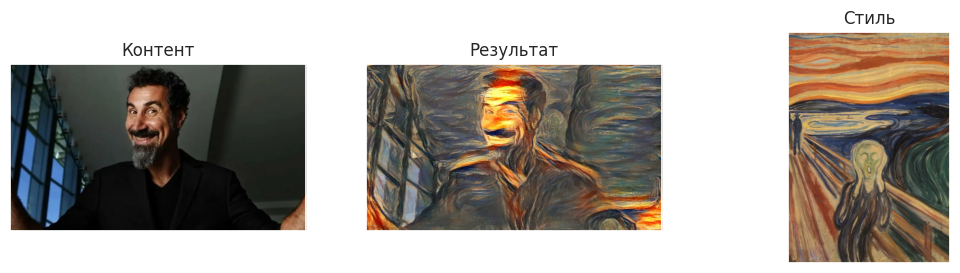

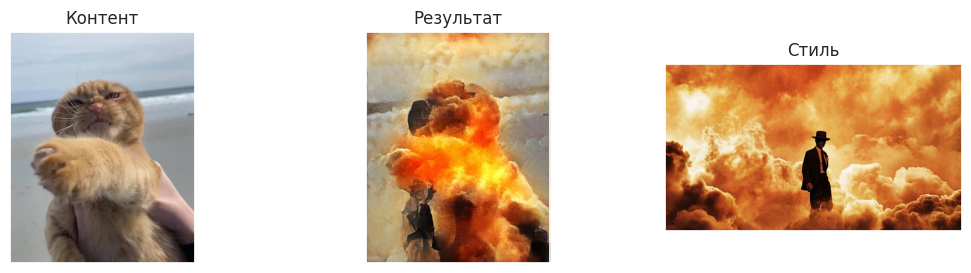

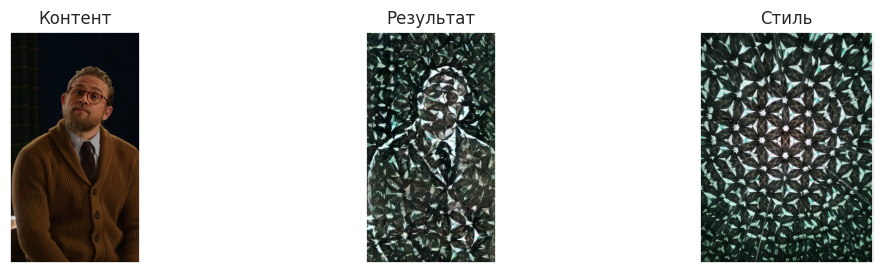

In [27]:
# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [28]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00



In [29]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 

```

pip install accelerate

```

.


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

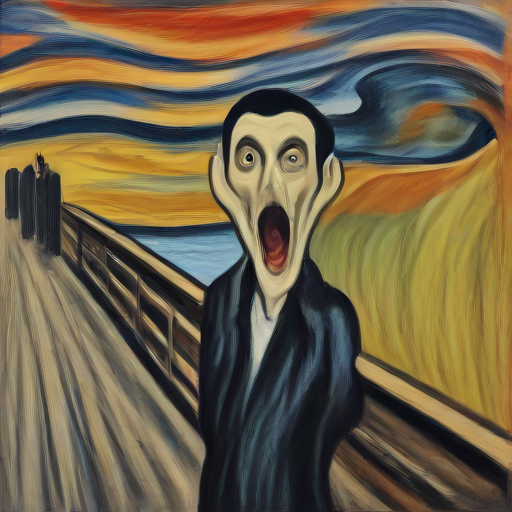

In [30]:
prompt = "Serge Tankian in the style of Edvard Munch's Painting The Scream"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

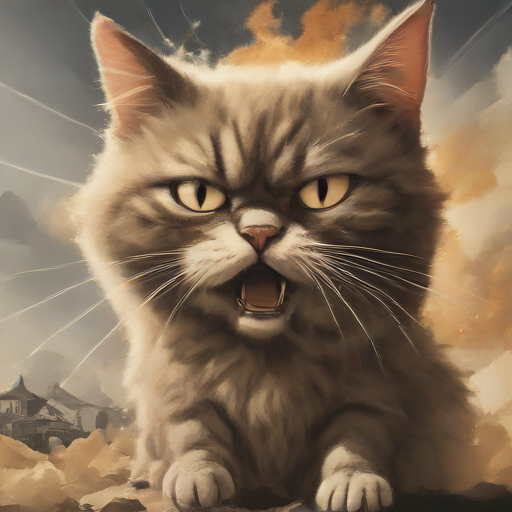

In [31]:
prompt = (
    "An angry cat in the style of a nuclear bomb explosion from Oppenheimer hits you"
)

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

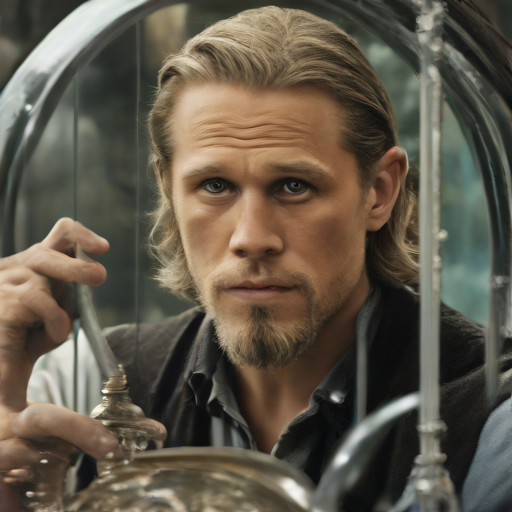

In [32]:
prompt = "Charlie Hunnam through the Looking Glass"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Вывод:**
Итак, как мы видим, наложение стиля на картину и создание картинк по описаниию сработали совсем по-разному. Наложение стиля действительно сработало, как ожидалось, хоть и не так качественно (например, вторая картинка немного исказилась из-за темной фигуры Оппенгеймера, а первая картинка размазалась). Создание же картинки по тексту сработало иначе - более бувально. Оно и понятно, ведь однозначного запроса наложения стиля не было. Так что обе модели сработали, так, как от них ожидается.